[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Fine-Tune YOLO for Cell Counting**

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

## 🎯 Objective

This notebook provides an end-to-end walkthrough for building an automated cell counting tool using a fine-tuned YOLOv8 model. The project covers the entire process from downloading a dataset with json annotations and converting it for training, to fine-tuning a detection model and deploying it to count cells in a video of microscopic imagery.


## 🚀 Key Features

* **Data Preparation**: Download a dataset from Kaggle and convert annotations from CSV format to the required YOLO `.txt` format.
* **Model Training**: Fine-tune a YOLOv8 nano detection model on a custom cell image dataset.
* **Video Processing Pipeline**: Develop a function to process video frames in real-time, count the detected cells, and display the count as a visual overlay.


## 📚 Libraries & Prerequisites

* **Core Libraries**: `ultralytics`, `opencv-python`, `matplotlib`.
* **Environment**: A Python environment with GPU support for efficient training.
* **Dataset**: A dataset of cell images with corresponding annotations in a json file, and a video for inference.


## Annotate your Custom dataset using Labellerr

 ***1. Visit the [Labellerr](https://www.labellerr.com/?utm_source=githubY&utm_medium=social&utm_campaign=github_clicks) website and click **“Sign Up”**.*** 

 ***2. After signing in, create your workspace by entering a unique name.***

 ***3. Navigate to your workspace’s API keys page (e.g., `https://<your-workspace>.labellerr.com/workspace/api-keys`) to generate your **API Key** and **API Secret**.***

 ***4. Store the credentials securely, and then use them to initialise the SDK or API client with `api_key`, `api_secret`.*** 


### Use Labellerr SDK for uploading and perform annotation of your own dataset

In [ ]:
# uncomment the following lines to install required packages in a Jupyter notebook environment

# !pip install git+https://github.com/Labellerr/SDKPython.git
# !pip install ipyfilechooser
# !git clone https://github.com/Labellerr/yolo_finetune_utils.git

In [ ]:
# all the imports required for this notebook
from labellerr.client import LabellerrClient
from labellerr.core.datasets import create_dataset_from_local
from labellerr.core.annotation_templates import create_template
from labellerr.core.projects import create_project
from labellerr.core.schemas import DatasetConfig, AnnotationQuestion, QuestionType, CreateTemplateParams, DatasetDataType, CreateProjectParams, RotationConfig
from labellerr.core.projects import LabellerrProject
from labellerr.core.exceptions import LabellerrError

import uuid
from ipyfilechooser import FileChooser

In [ ]:
api_key = input("YOUR_API_KEY")        # go to labellerr workspace to get your API key
api_secret = input("YOUR_API_SECRET")  # go to labellerr workspace to get your API secret
client_id = input("YOUR_CLIENT_ID")   # Contact labellerr support to get your client ID i.e. support@tensormatics.com

client = LabellerrClient(api_key, api_secret, client_id)


### ***STEP-1: Create a dataset on labellerr from your local folder***

The SDK supports in creating dataset by uploading local files. 

In [ ]:
# Create a folder chooser starting from a directory (for example, your home directory)
chooser = FileChooser('/')

# Set the chooser to folder selection mode only
chooser.title = 'Select a folder containing your dataset'
chooser.show_only_dirs = True

# Display the widget
display(chooser)

FileChooser(path='D:\', filename='', title='Select a folder containing your dataset', show_hidden=False, selec…

In [ ]:
path_to_dataset = chooser.selected_path
print("You selected:", path_to_dataset)

You selected: D:\Professional\Projects\Cell_Segmentation_using_YOLO\frames_output


In [ ]:
my_dataset_type = input("Enter your dataset type (video or image): ").lower()
print("Selected dataset type:", my_dataset_type)

Selected dataset type: video


In [ ]:
dataset = create_dataset_from_local(
    client=client,
    dataset_config=DatasetConfig(dataset_name="My Dataset", data_type="image"),
    folder_to_upload=path_to_dataset
)

print(f"Dataset created with ID: {dataset.dataset_id}")


### ***STEP-2: Create annotation project on labellerr of your created dataset***

Create a annotation project of your uploaded dataset to start performing annotation on labellerr UI

In [ ]:
# Create annotation guideline template for video annotation project (like classes to be annotated)

template = create_template(
    client=client,
    params=CreateTemplateParams(
        template_name="My Template",
        data_type=DatasetDataType.image,
        questions=[
            AnnotationQuestion(
                question_number=1,
                question="Object",
                question_id=str(uuid.uuid4()),
                question_type=QuestionType.polygon,
                required=True,
                color="#FF0000"
            )
        ]
    )
)
print(f"Annotation template created with ID: {template.annotation_template_id}")


In [ ]:
dataset.status()        # wait until dataset is processed before creating project

project = create_project(
    client=client,
    params=CreateProjectParams(
        project_name="My Project",
        data_type=DatasetDataType.image,
        rotations=RotationConfig(
            annotation_rotation_count=1,
            review_rotation_count=1,
            client_review_rotation_count=1
        )
    ),
    datasets=[dataset],
    annotation_template=template
)

print(f"✓ Project created: {project.project_id}")

Your project has been created now go to labellerr platform to perform annotation 

***click to go to labellerr.com***

[![Labellerr](https://cdn.labellerr.com/1%20%20Documentation/1c9dc7ce-9a54-4111-8fd5-0363ba3e00e1.webp)](https://www.labellerr.com/?utm_source=githubY&utm_medium=social&utm_campaign=github_clicks)
Open the project you created (Projects → select your project).

Click Start Labeling to open the annotation interface. Use the configured labeling tools (bounding boxes, polygon, dot, classification, etc.) to annotate files.
### ***STEP-3: Export your annotation in required format***

Generate a temporary download URL to retrieve your exported JSON file:

### Export Configuration Parameters

| Parameter | Type | Description |
|-----------|------|-------------|
| `export_name` | string | Display name for the export |
| `export_description` | string | Description of what this export contains |
| `export_format` | string | Output format (e.g., `json`, `xml`, `coco`) |
| `statuses` | list | Annotation statuses to include in export |

### Common Annotation Statuses

- **`review`**: Annotations pending review
- **`r_assigned`**: Review assigned to a reviewer
- **`client_review`**: Under client review
- **`cr_assigned`**: Client review assigned
- **`accepted`**: Annotations accepted and finalized

---

In [ ]:
export_config = {
    "export_name": "Weekly Export",
    "export_description": "Export of all accepted annotations",
    "export_format": "coco_json",
    "statuses": ['review', 'r_assigned','client_review', 'cr_assigned','accepted']
}

try:
    # Get project instance
    project = LabellerrProject(client=client, project_id=project.project_id)
    
    # Create export
    result = project.create_local_export(export_config)
    export_id = result["response"]['report_id']
    print(f"Local export created successfully. Export ID: {export_id}")
except LabellerrError as e:
    print(f"Local export creation failed: {str(e)}")
    
    
try:
    download_url = client.fetch_download_url(
        project_id=project.project_id,
        uuid=str(uuid.uuid4()),
        export_id=export_id
    )
    print(f"Download URL: {download_url}")
except LabellerrError as e:
    print(f"Failed to fetch download URL: {str(e)}")


Now you can download your annotations locally using given URL

## **Dataset Annotation Preparation**

We begin by downloading and preparing the dataset.

In [1]:
!git clone https://github.com/Labellerr/yolo_finetune_utils.git

Cloning into 'yolo_finetune_utils'...


In [2]:
from yolo_finetune_utils.video_annotation.yolo_converter import convert_to_yolo_segmentation

In [3]:
convert_to_yolo_segmentation(
        annotation_path="annotations.json",
        videos_dir="dataset",
        use_split=True,
        split_ratio=(0.5, 0.4, 0.1),  # 50% train, 40% val, 10% test
        output_dir="yolo_format"
    )

Using split ratio: Train=0.5, Val=0.4, Test=0.1
Creating output directory structure in: yolo_format
Loading JSON annotation file...
Found classes: ['Red Blood Cell']
Aggregating annotations from JSON...


Processing files in JSON: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]



Extracting frames and saving to YOLO format...
Processing train set (167 frames)...


Exporting train set: 100%|██████████| 167/167 [00:33<00:00,  4.96it/s]


Processing val set (134 frames)...


Exporting val set: 100%|██████████| 134/134 [00:27<00:00,  4.82it/s]


Processing test set (34 frames)...


Exporting test set: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]


Creating data.yaml file...

Conversion complete! ✨
Dataset saved to: d:\professional\USE_CASE_PROJECT\Biotechnology\yolo_format
YAML file saved to: d:\professional\USE_CASE_PROJECT\Biotechnology\yolo_format\data.yaml


### **Model Training**

With our dataset correctly formatted, we proceed to train the YOLOv8 model. We use a pre-trained `yolov8x-seg.pt` checkpoint to leverage transfer learning, fine-tuning it on our custom cell dataset for 250 epochs.

In [8]:
!yolo task=segment mode=train data="./yolo_format/data.yaml" model="yolov8x-seg.pt" epochs=250 imgsz=640 batch=15

New https://pypi.org/project/ultralytics/8.3.195 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.168 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA L4, 22491MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./yolo_format/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=Fal

### **Cell Counting Logic**

In [13]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
import cv2

In [14]:
model = YOLO("runs/segment/train/weights/last.pt")

Total Cells Detected: 300


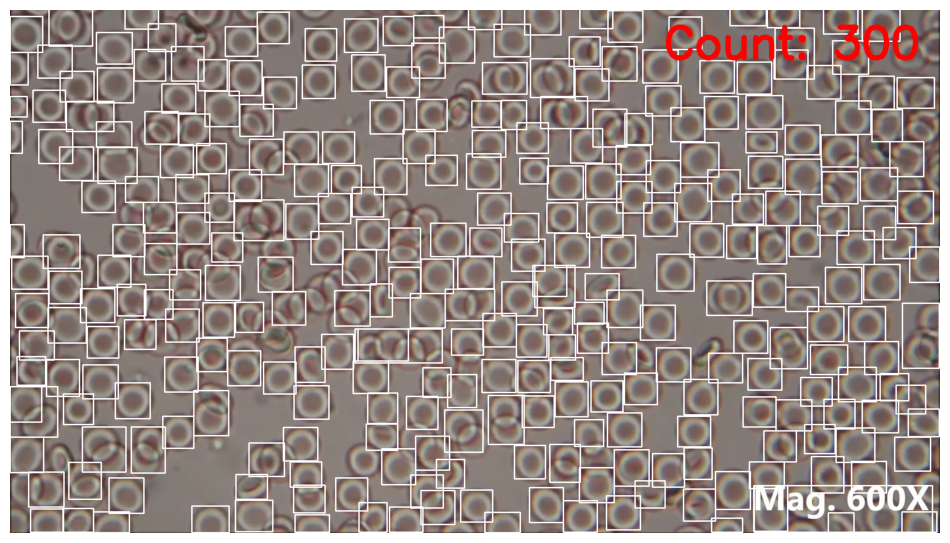

In [22]:
image_path = "./yolo_format/images/test/sample_2_frame_146.jpg"

frame = cv2.imread(image_path)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

result= model.predict(source=image_path , conf=0.01, show_labels=False, show_conf=False)


for box in result[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 255), 2)

count = len(result[0].boxes)
cv2.putText(frame, f'Count: {count}', (1350, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 10)
print(f"Total Cells Detected: {count}")

    
plt.figure(figsize=(12, 8))
plt.axis('off')  # Hide axes
plt.imsave("./cell_count_output_2.jpg", frame)
plt.imshow(frame)

### **Inference Custom Model on Video**

In [11]:
!yolo task=segment mode=predict model="runs/segment/train/weights/last.pt" source="./dataset/sample_3.mp4" conf=0.2 show_labels=False show_conf=False save=True

Ultralytics 8.3.168 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA L4, 22491MiB)
YOLOv8x-seg summary (fused): 125 layers, 71,721,619 parameters, 0 gradients, 343.7 GFLOPs

video 1/1 (frame 1/308) /home/HP/USE_CASE_PROJECT/Biotechnology/dataset/sample_3.mp4: 384x640 55 Red Blood Cells, 75.3ms
video 1/1 (frame 2/308) /home/HP/USE_CASE_PROJECT/Biotechnology/dataset/sample_3.mp4: 384x640 56 Red Blood Cells, 12.3ms
video 1/1 (frame 3/308) /home/HP/USE_CASE_PROJECT/Biotechnology/dataset/sample_3.mp4: 384x640 55 Red Blood Cells, 13.8ms
video 1/1 (frame 4/308) /home/HP/USE_CASE_PROJECT/Biotechnology/dataset/sample_3.mp4: 384x640 54 Red Blood Cells, 14.2ms
video 1/1 (frame 5/308) /home/HP/USE_CASE_PROJECT/Biotechnology/dataset/sample_3.mp4: 384x640 54 Red Blood Cells, 12.5ms
video 1/1 (frame 6/308) /home/HP/USE_CASE_PROJECT/Biotechnology/dataset/sample_3.mp4: 384x640 54 Red Blood Cells, 12.1ms
video 1/1 (frame 7/308) /home/HP/USE_CASE_PROJECT/Biotechnology/dataset/sample_3.mp4: 384x640 54 Re

Finally, we create a script to apply our counting logic to a full video. This function reads the video frame by frame, passes each frame to the `get_counts` function for processing and annotation, and then saves the result as a new, annotated video file.

In [21]:
# Input & output video paths
video_path = "./dataset/sample_2.mp4"
output_path = "live_cell_count_output_2.mp4"

# Open video
cap = cv2.VideoCapture(video_path)

# Video writer setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run inference
    results = model(frame, verbose=False)

    # Extract detections
    detections = results[0].boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    classes = results[0].boxes.cls.cpu().numpy().astype(int)
    names = model.names
    total_detections = len(detections)

    # Draw bounding boxes
    for box, cls in zip(detections, classes):
        x1, y1, x2, y2 = map(int, box)
        label = names[cls]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 255), 2)
        # cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Annotate total detections (upper right)
    text = f"Count: {total_detections}"
    cv2.putText(frame, text, (width - 570, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 10)

    # Write frame
    out.write(frame)

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"✅ Saved annotated video as {output_path}")


✅ Saved annotated video as live_cell_count_output_2.mp4


---

## 👨‍💻 About Labellerr's Hands-On Learning in Computer Vision

Thank you for exploring this **Labellerr Hands-On Computer Vision Cookbook**! We hope this notebook helped you learn, prototype, and accelerate your vision projects.  
Labellerr provides ready-to-run Jupyter/Colab notebooks for the latest models and real-world use cases in computer vision, AI agents, and data annotation.

---
## 🧑‍🔬 Check Our Popular Youtube Videos

Whether you're a beginner or a practitioner, our hands-on training videos are perfect for learning custom model building, computer vision techniques, and applied AI:

- [How to Fine-Tune YOLO on Custom Dataset](https://www.youtube.com/watch?v=pBLWOe01QXU)  
  Step-by-step guide to fine-tuning YOLO for real-world use—environment setup, annotation, training, validation, and inference.
- [Build a Real-Time Intrusion Detection System with YOLO](https://www.youtube.com/watch?v=kwQeokYDVcE)  
  Create an AI-powered system to detect intruders in real time using YOLO and computer vision.
- [Finding Athlete Speed Using YOLO](https://www.youtube.com/watch?v=txW0CQe_pw0)  
  Estimate real-time speed of athletes for sports analytics.
- [Object Counting Using AI](https://www.youtube.com/watch?v=smsjBBQcIUQ)  
  Learn dataset curation, annotation, and training for robust object counting AI applications.
---

## 🎦 Popular Labellerr YouTube Videos

Level up your skills and see video walkthroughs of these tools and notebooks on the  
[Labellerr YouTube Channel](https://www.youtube.com/@Labellerr/videos):

- [How I Fixed My Biggest Annotation Nightmare with Labellerr](https://www.youtube.com/watch?v=hlcFdiuz_HI) – Solving complex annotation for ML engineers.
- [Explore Your Dataset with Labellerr's AI](https://www.youtube.com/watch?v=LdbRXYWVyN0) – Auto-tagging, object counting, image descriptions, and dataset exploration.
- [Boost AI Image Annotation 10X with Labellerr's CLIP Mode](https://www.youtube.com/watch?v=pY_o4EvYMz8) – Refine annotations with precision using CLIP mode.
- [Boost Data Annotation Accuracy and Efficiency with Active Learning](https://www.youtube.com/watch?v=lAYu-ewIhTE) – Speed up your annotation workflow using Active Learning.

> 👉 **Subscribe** for Labellerr's deep learning, annotation, and AI tutorials, or watch videos directly alongside notebooks!

---

## 🤝 Stay Connected

- **Website:** [https://www.labellerr.com/](https://www.labellerr.com/)
- **Blog:** [https://www.labellerr.com/blog/](https://www.labellerr.com/blog/)
- **GitHub:** [Labellerr/Hands-On-Learning-in-Computer-Vision](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
- **LinkedIn:** [Labellerr](https://in.linkedin.com/company/labellerr)
- **Twitter/X:** [@Labellerr1](https://x.com/Labellerr1)

*Happy learning and building with Labellerr!*
